In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from sklearn.naive_bayes import GaussianNB

def bayes(X_train, y_train):
    bay = GaussianNB()
    bay.fit(X_train, y_train)

    return bay

from sklearn.linear_model import LogisticRegression

def logistic_reg(X_train, y_train):
    logreg = LogisticRegression(max_iter=10000)
    logreg.fit(X_train, y_train)

    return logreg

from sklearn.neighbors import KNeighborsClassifier

def kNN(X_train, y_train):
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train, y_train)

    return neigh

In [3]:
def set_season(dataframe):
    dataframe = dataframe.copy(deep=True)
    date_col = dataframe["Date"]
    date_ids = np.full((len(date_col)), "")
    for index, date in enumerate(date_col):
        month = int(date.split("-")[1])
        if (month >= 3 and month <= 5):
            month_id = "f"
        elif (month >= 6 and month <= 8):
            month_id = "s"
        elif (month >= 9 and month <= 11):
            month_id = "a"
        else:
            month_id = "w"

        date_ids[index] = month_id
    dataframe.loc[:, "Season"] = date_ids
    dataframe.drop(["Date"], axis=1, inplace=True)

    return dataframe

In [4]:
categories = ["Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "Season"]

def prepare_dataset(dataframe, drop=[]):
    dataframe = dataframe.copy(deep=True)
    dataframe = dataframe.dropna(subset=["RainTomorrow"])
#     dataframe.drop(["Sunshine", "Evaporation", "Cloud9am",  "Cloud3pm"], axis=1, inplace=True)
    dataframe = set_season(dataframe)
    
    dataframe = dataframe.dropna(thresh=2)
    
    labels = dataframe["RainTomorrow"]
    dataframe.drop(["RainTomorrow"], axis=1, inplace=True)
    
    for feature_name in dataframe:
        if feature_name in categories:
            dataframe[feature_name].fillna(dataframe[feature_name].value_counts().idxmax(), inplace=True)
        else:
            dataframe[feature_name].fillna(dataframe[feature_name].median(), inplace=True)
            mean_val = np.mean(dataframe[feature_name])
            dispersion = np.std(dataframe[feature_name])**2
            dataframe.loc[:, feature_name] = (np.array(dataframe[feature_name]) - mean_val)/dispersion
            
    for feature_name in drop:
        dataframe.drop([feature_name], axis=1, inplace=True)
    
    for feature_name in dataframe:
        if (feature_name not in drop and feature_name in categories):
            dataframe = pd.concat([dataframe, pd.get_dummies(dataframe[[feature_name]], columns=[feature_name], drop_first=False)], axis=1)
            dataframe.drop([feature_name], axis=1, inplace=True)
    
    return dataframe, labels

In [5]:
def balance_classes(dataframe, labels):
    dataframe = dataframe.copy(deep=True)
    dataframe.loc[:, "RainTomorrow"] = labels
    dataframe.sample(frac=1).reset_index(drop=True)
    
    YesClass = dataframe[dataframe["RainTomorrow"] == "Yes"]
    NoClass = dataframe[dataframe["RainTomorrow"] == "No"]
    
    drop_num = len(NoClass) - len(YesClass)
    drop_indices = np.random.choice(NoClass.index, drop_num, replace=False)
    NoClass = NoClass.drop(drop_indices)

    dataframe = pd.concat((YesClass, NoClass))
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    
    labels = dataframe["RainTomorrow"]
    dataframe.drop(["RainTomorrow"], axis=1, inplace=True)
    
    return dataframe, labels

In [6]:
def plot_correlation_matrix(dataframe):
    corr_mtrx = np.corrcoef(dataframe.values, rowvar=False)
    f = plt.figure(figsize=(8, 8))
    plt.matshow(corr_mtrx, fignum=f.number)
    plt.xticks(range(corr_mtrx.shape[1]), fontsize=9, rotation=45)
    plt.yticks(range(corr_mtrx.shape[1]), fontsize=9)
    cb = plt.colorbar()
    plt.title('Correlation Matrix', fontsize=10)
    plt.show()

In [7]:
def convert_y(y_test):
    y_new = np.full(len(y_test), 0, dtype=np.float64)
    for ind, element in enumerate(y_test):
        if element == "Yes":
            y_new[ind] = 1
        else:
            y_new[ind] = 0

    return y_new

In [8]:
import time

def timeit(func):
    def wrapper(*args, **kwargs):
        t = time.time()
        res = func(*args, **kwargs)
        print(f"Time passed: {round(time.time() - t)} s.")
        return res
    return wrapper

In [9]:
def plot_curves(y_test, proba):
    y_test = convert_y(y_test)
    fpr, tpr, thresholds    = roc_curve(y_test, proba)
    prc, rec, thresholds_   = precision_recall_curve(y_test, proba)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    
    ax1.plot(fpr, tpr, label="ROC")
    ax1.set_title('ROC curve')
    ax1.set_xlabel('FPR')
    ax1.set_ylabel('TPR')
    ax1.set_box_aspect(1)
    
    ax2.plot(rec, prc, label="PRC")
    ax2.set_title('PRC curve')
    ax2.set_xlabel('REC')
    ax2.set_ylabel('PRC')
    ax2.set_box_aspect(1)
    
    plt.show()
    print(f"AROC: {roc_auc_score(y_test, proba)}")
    print(f"APRC: {auc(rec, prc)}")

In [10]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, auc, classification_report

def evaluate(model, X_test, y_test, method=""):
    prediction = model.predict(X_test)
    proba = model.predict_proba(X_test)
    
    print(classification_report(y_test, prediction))
    
    plot_curves(y_test, proba[:, 1])
    plot_correlation_matrix(dataframe)

In [11]:
@timeit
def train_and_evaluate(classifier, X_train, X_test, y_train, y_test):
    cl = classifier(X_train, y_train)
    evaluate(cl, X_test, y_test)

LOGISTIC REGRESSION
              precision    recall  f1-score   support

          No       0.87      0.95      0.91     27440
         Yes       0.74      0.51      0.60      8109

    accuracy                           0.85     35549
   macro avg       0.80      0.73      0.76     35549
weighted avg       0.84      0.85      0.84     35549



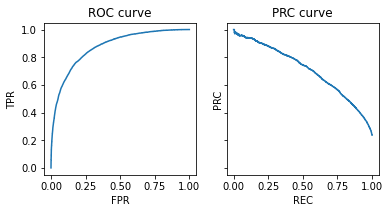

AROC: 0.872861615445819
APRC: 0.7096424414359257


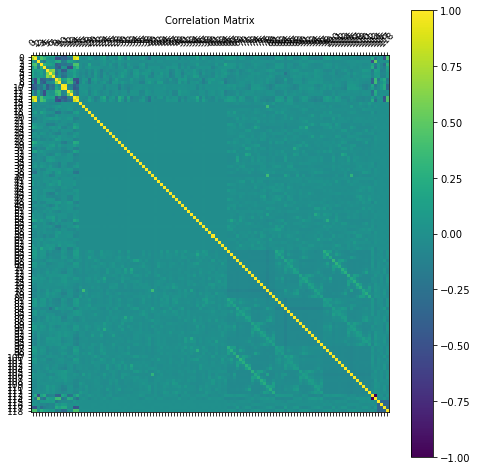

Time passed: 7 s.


In [12]:
Dataframe = pd.read_csv("weatherAUS.csv")
dataframe, labels = prepare_dataset(Dataframe, drop=[])

X_train, X_test, y_train, y_test = train_test_split(dataframe, labels, test_size = 0.25, shuffle=True)

print("LOGISTIC REGRESSION")
train_and_evaluate(logistic_reg, X_train, X_test, y_train, y_test)

BAYES
              precision    recall  f1-score   support

          No       0.88      0.61      0.72     27628
         Yes       0.34      0.70      0.46      7921

    accuracy                           0.63     35549
   macro avg       0.61      0.66      0.59     35549
weighted avg       0.76      0.63      0.66     35549



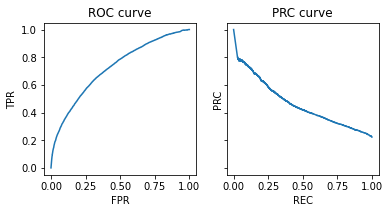

AROC: 0.7213079319347033
APRC: 0.46531447305439894


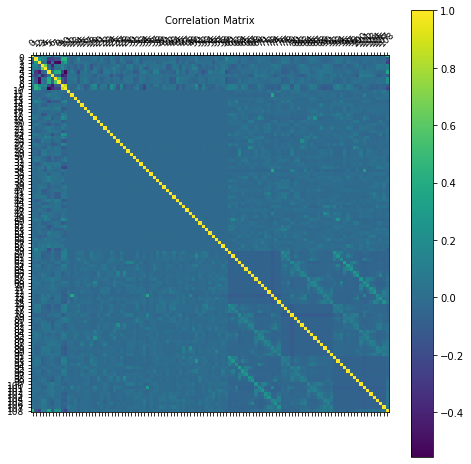

Time passed: 3 s.


In [13]:
Dataframe = pd.read_csv("weatherAUS.csv")
drop = ["RainToday_No"]
dataframe, labels = prepare_dataset(Dataframe, drop=["Season", "MaxTemp", "MinTemp", "WindSpeed9am", "Humidity9am", "Pressure9am"])
dataframe.drop(drop, axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(dataframe, labels, test_size = 0.25, shuffle=True)

print("BAYES")
train_and_evaluate(bayes, X_train, X_test, y_train, y_test)

KNN
              precision    recall  f1-score   support

          No       0.84      0.90      0.87     27575
         Yes       0.55      0.43      0.48      7974

    accuracy                           0.79     35549
   macro avg       0.70      0.66      0.68     35549
weighted avg       0.78      0.79      0.78     35549



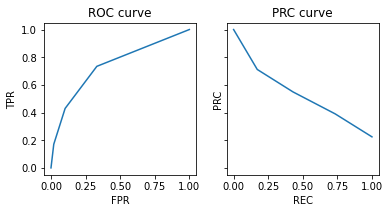

AROC: 0.7394521155677983
APRC: 0.5340121039102982


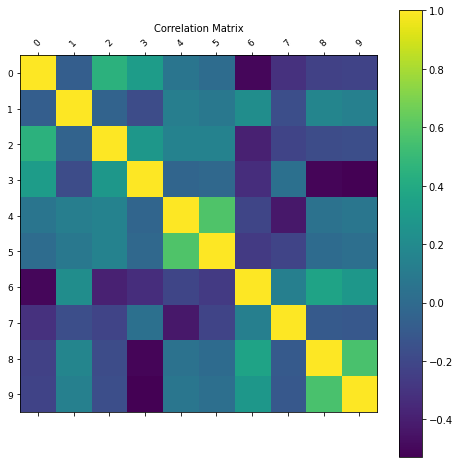

Time passed: 12 s.


In [14]:
Dataframe = pd.read_csv("weatherAUS.csv")
drop = ["MinTemp", "WindSpeed3pm", "Humidity3pm", "Pressure3pm", "Temp3pm", "Temp9am"]
dataframe, labels = prepare_dataset(Dataframe, drop=categories)
dataframe.drop(drop, axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(dataframe, labels, test_size = 0.25, shuffle=True)

print("KNN")
train_and_evaluate(kNN, X_train, X_test, y_train, y_test)

В случае предсказания погоды логично оптимизировать метрику recall для класса "No", так как лучше, если человек
лишний раз возьмёт с собой зонтик, увидев неверный прогноз, чем промокнет. Полные результаты представлены выше.
Сводные результаты для метрики recall:
Логистическая регрессия:    0.95
Байесовский классификатор:  0.61
К ближайших соседей:        0.90

Лучшие результаты показала логистическая регрессия(max_iter=10000)

Во время подготовки данных был добавлена фича "Season", получаемый из даты("Date"). Отброшены все записи, где
количество NaNов больше одного. Были восстановлены пропущенные данные в встолбцах(взята мода для категориальных
данных и медиана для непрерывных). Непрерывные данные были масштабированы по формуле (x-mean(x))/sigma.
Также была написана функция балансировки классов, но как показала практика, балансировка только ухудшает
результаты для всех трёх моделей. Для модели байесовского классификатора были убраны основные кореллирующие
фичи. Для метода ближайших соседей была уменьшена размерность входных данных путём отбрасывания всех кореллирующих
и всех категориальных признаков.

Время выполнения и оценки для всех моделей примерно одинаковое, но всё же быстрее всего работает байесовский
классификатор.
Логистическая регрессия:    7  с.
Байесовский классификатор:  3  с.
К ближайших соседей:        12 с.

Однако, при добавлении категориальных признаков в метод ближайших соседей, время применения готового
классификатора значительно увеличивается(в 7-8 раз).